<a href="https://colab.research.google.com/github/analyticsariel/market-research-data/blob/main/Uncovering_Hidden_Real_Estate_Gems_Through_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncovering Hidden Real Estate Gems Through Data Science 🏘️💡

## Overview 📋

**Objective:**  
- To explore economic trends and real estate metrics from US Census and property data.  
- Develop a geographic score that highlights potential new markets for investment.

**Case Study Focus:**  
- Comparing neighborhood (census tract) metrics against state benchmarks.  
- Visualizing trends (e.g., median household income, new construction, and renovation signals).

**Data Sources & Tools:**  
- **Data:** US Census ACS (5-year estimates), public property datasets  
- **Tools:** Python, Pandas, GeoPandas, Plotly, and Transformers for NLP  
- **Visualization:** Interactive maps using Plotly and choropleth mapping

## Getting Started 🚀

1. **Copy the Notebook:**  
   - Go to `File > Save a copy in Drive` if you are using Google Colab.
2. **Installation:**  
   - Make sure you have all required packages installed (see next cell).
3. **Follow Along:**  
   - Each cell is accompanied by notes for the presenter and contextual explanations.

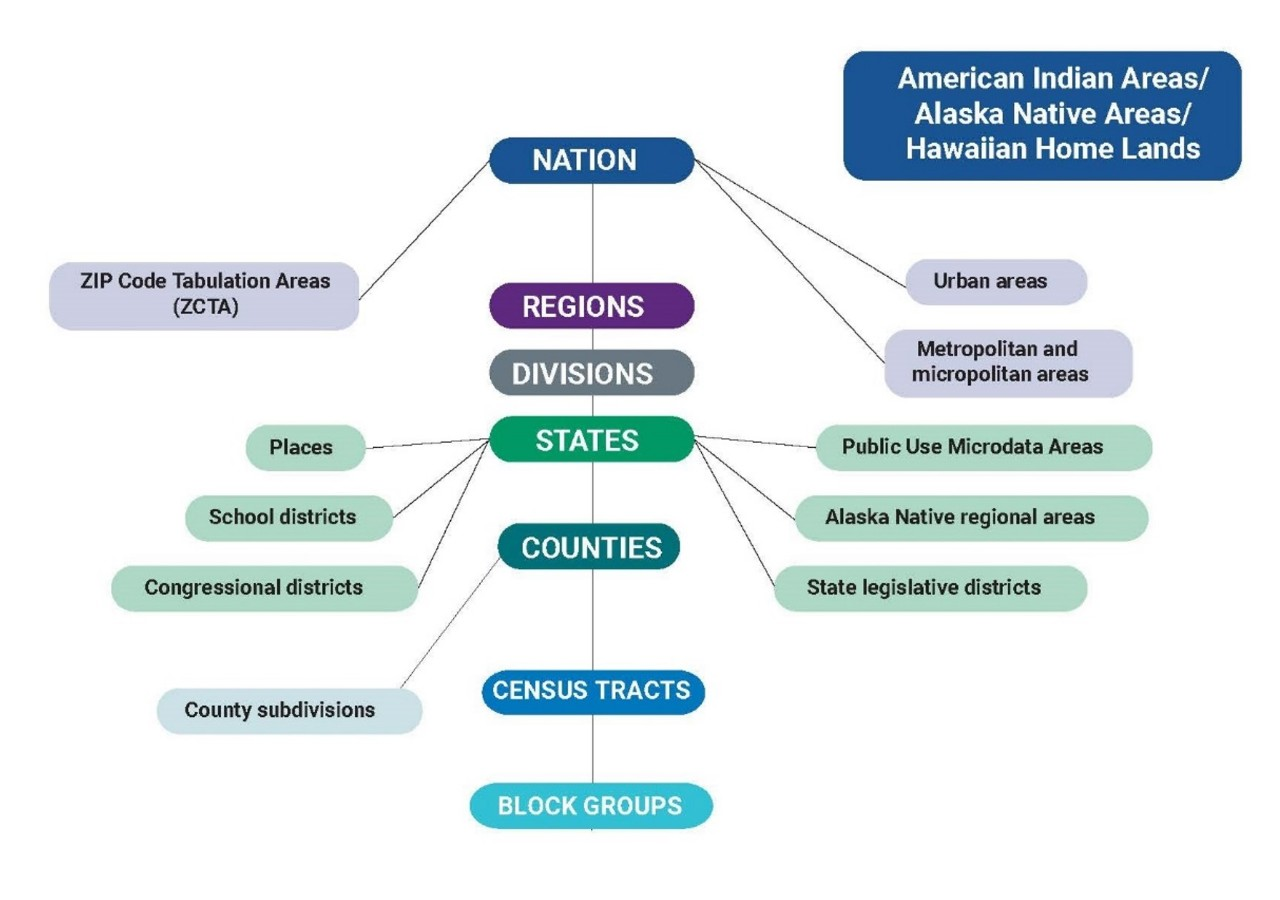

In [1]:
from PIL import Image
import requests
url = 'https://www.census.gov/programs-surveys/acs/geography-acs/concepts-definitions/_jcr_content/root/responsivegrid/expcolaccordioncore209/section_1/imagecore.coreimg.jpeg/1678878894635/acs-geographic-hierarchy.jpeg'
Image.open(requests.get(url, stream=True).raw)

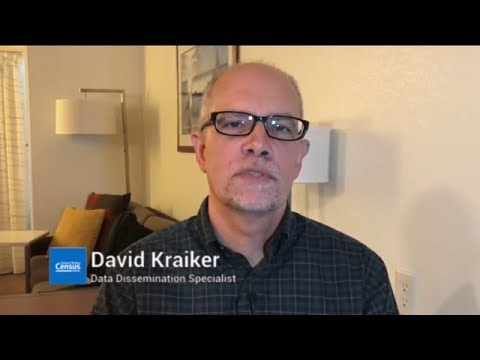

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('DOe4alPmjss') # source: https://www.census.gov/data/academy/data-gems/2018/tract.html

## Install Packages & Imports 📦

To ensure reproducibility, install and import all necessary packages.

In [3]:
# Install necessary packages (uncomment if running locally or in a fresh environment)
!pip install geopandas plotly transformers

# Import libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import warnings
from datetime import datetime
from google.colab import files
from PIL import Image
import requests

# Configure settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Helper Functions 🛠️

This section defines reusable functions for:
- Calculating geographic centers,
- Plotting interactive maps,
- Computing percentage differences, and
- Aggregating economic metrics into a neighborhood score.

In [4]:
def get_center_lat_lon(p):
    """
    Calculate the geographic center (latitude, longitude) for a polygon.

    Args:
        p (str): Polygon string representation.

    Returns:
        list: [center_lon, center_lat] rounded to 6 decimals.
    """
    lat_lon_list = [x.split(' ') for x in p.replace('(', '').replace(')', '').replace('MULTIPOLYGON ', '').replace('POLYGON ', '').split(', ')]
    center_lon = round(sum([float(x[0]) for x in lat_lon_list]) / len(lat_lon_list), 6)
    center_lat = round(sum([float(x[1]) for x in lat_lon_list]) / len(lat_lon_list), 6)
    return [center_lon, center_lat]

def plot_choropleth_map(df_plot, plot_county_name, plot_field):
    """
    Plots an interactive choropleth map using Plotly based on geographic data.

    Args:
        df_plot (DataFrame): DataFrame with geometry and economic data.
        plot_county_name (str): The county to filter on.
        plot_field (str): The data field to visualize (e.g., income).

    Returns:
        Plotly Figure object.
    """
    df_plot = df_plot.loc[df_plot['county'].str.contains(plot_county_name)]
    center_lat_lon = get_center_lat_lon(str(df_plot['geometry'].iloc[0]))
    fig = px.choropleth_mapbox(df_plot,
                               geojson=df_plot.geometry,
                               locations=df_plot.index,
                               color=plot_field,
                               color_continuous_scale='Viridis',
                               opacity=0.5,
                               center={"lat": center_lat_lon[1], "lon": center_lat_lon[0]},
                               mapbox_style="open-street-map",
                               zoom=8.5,
                               title=f'{plot_county_name}, FL: {" ".join(plot_field.split("_"))}')
    return fig

def percentage_diff(val1, val2):
    """
    Calculate the percentage difference between two values.

    Args:
        val1 (float): First value.
        val2 (float): Second value.

    Returns:
        float: The percentage difference.
    """
    return (val1 - val2) / val2

def economics_neighborhood_map_score(c, growth_yr='1'):
    """
    Compute a composite score by comparing tract metrics to state metrics.

    Args:
        c (dict-like): Contains both tract and state economic values.
        growth_yr (str): Indicator for year-over-year change.

    Returns:
        float: Neighborhood score (ratio of positive relative indicators).
    """
    c_score_d = {
        # Population growth
        'ratioPopGrowthState': percentage_diff(c[f'total_population_{growth_yr}_yr'], c[f'total_population_{growth_yr}_yr_state']),
        # Median household income
        'ratioMhiState': percentage_diff(c['median_household_income'], c['median_household_income_state']),
        # Rent
        'ratioRentState': percentage_diff(c['gross_rent'], c['gross_rent_state']),
        # Median home value
        'ratioMhvState': percentage_diff(c['median_home_value'], c['median_home_value_state']),
        # Employment rate
        'ratioEmployedState': percentage_diff(c['ratio_employed'], c['ratio_employed_state']),
        # Education bachelors degree or higher
        'ratioEducationBachelorDegreeHigherState': percentage_diff(c['ratio_bachelors_degree_or_higher'], c['ratio_bachelors_degree_or_higher_state']),
        # Vacancy rate
        'ratioVacantState': percentage_diff(c['ratio_vacant'], c['ratio_vacant_state']),
        # Owner occupied rate
        'ratioOwnerOccupiedState': percentage_diff(c['ratio_owner_occupied'], c['ratio_owner_occupied_state']),
        # New bulild rate
        'ratioNewerBuildsStateState': percentage_diff(c[f'ratio_newer_builds_{growth_yr}_yr'], c[f'ratio_newer_builds_{growth_yr}_yr_state']),
        # Work from home growth rate
        'ratioTransWfhGrowthState': percentage_diff(c[f'ratio_trans_wfh_{growth_yr}_yr'], c[f'ratio_trans_wfh_{growth_yr}_yr_state']),
        # Transprotation over 60 min
        'ratioTransTime60+GrowthState': percentage_diff(c[f'ratio_trans_time_60+_{growth_yr}_yr'], c[f'ratio_trans_time_60+_{growth_yr}_yr_state']),
    }

    # Score each economic indicator (1 if favorable, 0 otherwise)
    score_d = {}
    for k, v in c_score_d.items():
        if k in ['ratioVacantState', 'ratioTransTime60+GrowthState']:
            score_d[k] = 1 if v < 0 else 0
        else:
            score_d[k] = 1 if v > 0 else 0
    total_score = sum(score_d.values()) / len(score_d)
    return total_score

## Data Acquisition and Preparation 📊

### Reading Census Data
We load US Census ACS data directly from a public GitHub repository. The dataset contains economic and demographic metrics by census tract.

Census ACS Data 5-Year Estimate:
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

Python Code for Raw Data:
https://censusneighborhoodanalyzer.streamlit.app/Step_1_Get_Data

[Optional] Request a key to generate your own dataset [here](https://api.census.gov/data/key_signup.html)

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/analyticsariel/market-research-data/main/market_discover_acs_census_output_geo.csv')
df['county'] = df.apply(lambda x: x['name'].split(';')[1], axis=1)
print('Num of rows:', len(df))
print('Num of cols:', len(df.columns))
df.head(1)

Num of rows: 4856
Num of cols: 99


name  state  total_population  \
0  Census Tract 1.01; Collier County; Florida     12              1307   

   median_household_income  gross_rent  median_home_value  \
0                    71029        1231             793600   

   total_in_labor_workforce  total_not_in_labor_workforce  total_education  \
0                      1296                           915             1296   

   education_no_hs  education_hs  education_associates  education_bachelors  \
0               29           258                   305                  394   

   education_graduate  total_occupancy_status  occupancy_status_occupied  \
0                 310                    2080                        882   

   occupancy_status_vacant  total_home_tenure  home_tenure_owner_occupied  \
0                     1198                882                         765   

   home_tenure_renter_occupied  median_construction_year  total_housing_units  \
0                          117                      1981                 2080   

   housing_units_2020+  housing_units_2010-2029  total_work_transportation  \
0                    0                       87                        365   

   work_transportation_wfh  total_work_travel_time  work_travel_time_60-89min  \
0                      107                     258                          0   

   work_travel_time_90+ reporting_date region_type             geo_id  \
0                     0     2022-01-01       tract  GEOID 12021000101   

  usps_zip_pref_city  id_num_records  invalid_value  gross_rent_valid_flag  \
0             Naples               3          False                   True   

   ratio_employed  ratio_bachelors_degree_or_higher  ratio_vacant  \
0         0.58616                           0.54321      0.575962   

   ratio_owner_occupied  ratio_newer_builds  ratio_trans_wfh  \
0              2.965116            0.041827         0.293151   

   ratio_trans_time_60+  total_population_1_yr  total_population_2_yr  \
0                   0.0               0.052335              -0.028975   

   median_household_income_1_yr  median_household_income_2_yr  \
0                      0.134304                      0.185872   

   gross_rent_1_yr  gross_rent_2_yr  median_home_value_1_yr  \
0        -0.275882        -0.296571                0.084005   

   median_home_value_2_yr  ratio_employed_1_yr  ratio_employed_2_yr  \
0                0.203883             0.000059              0.01198   

   ratio_bachelors_degree_or_higher_1_yr  \
0                                -0.0093   

   ratio_bachelors_degree_or_higher_2_yr  ratio_vacant_1_yr  \
0                               0.001122          -0.012918   

   ratio_vacant_2_yr  ratio_owner_occupied_1_yr  ratio_owner_occupied_2_yr  \
0          -0.021359                  -0.040698                  -0.078873   

   ratio_newer_builds_1_yr  ratio_newer_builds_2_yr  ratio_trans_wfh_1_yr  \
0                  0.07892                 0.519712             -0.117999   

   ratio_trans_wfh_2_yr  ratio_trans_time_60+_1_yr  ratio_trans_time_60+_2_yr  \
0              0.032135                        NaN                       -1.0   

   total_population_state  median_household_income_state  gross_rent_state  \
0                21634529                          67917              1444   

   median_home_value_state  ratio_employed_state  \
0                   292200              0.711263   

   ratio_bachelors_degree_or_higher_state  ratio_vacant_state  \
0                                0.323332            0.157576   

   ratio_owner_occupied_state  ratio_newer_builds_state  \
0                    0.640874                  0.104486   

   ratio_trans_wfh_state  ratio_trans_time_60+_state  \
0               0.119357                     0.07502   

   total_population_1_yr_state  total_population_2_yr_state  \
0                     0.013813                     0.019683   

   median_household_income_1_yr_state  median_household_income_2_yr_state  \
0                     

### Reading Tract Data
Next, we load geographic tract data with GeoPandas. These data will help us generate maps showing how economic factors vary spatially.

In [6]:
# Load tract geographic data
# https://www2.census.gov/geo/tiger/TIGER2023/TRACT/
year = '2023'
state = '12'
df_tract = gpd.read_file(f'https://raw.githubusercontent.com/analyticsariel/market-research-data/main/tl_{year}_{state}_tract.zip')
print("Num of rows:", len(df_tract))
print("Num of columns:", len(df_tract.columns))
df_tract['geo_id'] = df_tract.apply(lambda x: 'GEOID ' + x['GEOID'], axis=1)
df_tract = df_tract[['geo_id', 'geometry']]
df_tract.head(1)

Num of rows: 5160
Num of columns: 14


geo_id                                           geometry
0  GEOID 12011010102  POLYGON ((-80.09511 26.2921, -80.0949 26.29341...

## Exploratory Data Analysis 🔍

### Descriptive Statistics & Distribution
We start by reviewing the basic statistics to gain insight into the dataset's distribution.

In [7]:
# review distribution of dataset
df.describe().applymap(lambda x: f"{x:0.2f}")

state total_population median_household_income gross_rent  \
count  4856.00          4856.00                 4856.00    4856.00   
mean     12.00          4313.62                73656.18    1552.42   
std       0.00          2030.71                31274.47     523.96   
min      12.00           336.00                13045.00      99.00   
25%      12.00          2889.75                52123.50    1186.00   
50%      12.00          4021.50                67741.50    1469.50   
75%      12.00          5396.00                88641.25    1811.25   
max      12.00         23706.00               250001.00    4347.00   

      median_home_value total_in_labor_workforce total_not_in_labor_workforce  \
count           4856.00                  4856.00                      4856.00   
mean          321451.53                  3563.67                      1442.51   
std           202921.45                  1582.54                       731.91   
min            12700.00                   284.00                        56.00   
25%           199900.00                  2437.00                       947.50   
50%           280150.00                  3344.50                      1315.00   
75%           385700.00                  4416.00                      1789.50   
max          2000001.00                 16386.00                     11183.00   

      total_education education_no_hs education_hs education_associates  \
count         4856.00         4856.00      4856.00              4856.00   
mean          3119.69          328.10       861.00               914.66   
std           1368.79          289.55       477.30               484.13   
min            247.00            0.00        11.00                12.00   
25%           2149.00          124.00       509.75               571.00   
50%           2929.00          249.00       789.00               828.00   
75%           3851.50          445.00      1127.00              1154.50   
max          13715.00         2825.00      3693.00              4438.00   

      education_bachelors education_graduate total_occupancy_status  \
count             4856.00            4856.00                4856.00   
mean               635.35             380.58                1982.19   
std                443.01             338.84                 843.51   
min                  0.00               0.00                 230.00   
25%                318.00             147.75                1381.00   
50%                546.00             286.00                1863.00   
75%                835.25             506.00                2451.25   
max               4649.00            5597.00                8790.00   

      occupancy_status_occupied occupancy_status_vacant total_home_tenure  \
count                   4856.00                 4856.00           4856.00   
mean                    1670.23                  311.96           1670.23   
std                      715.74                  382.54            715.74   
min                      118.00                    0.00            118.00   
25%                     1161.00                   96.00           1161.00   
50%                     1576.00                  202.50           1576.00   
75%                     2066.25                  388.00           2066.25   
max                     7737.00                 7057.00           7737.00   

      home_tenure_owner_occupied home_tenure_renter_occupied  \
count                    4856.00                     4856.00   
mean                     1132.34                      537.90   
std                       624.83                      440.59   
min                        24.00                        0.00   
25%                       691.75                      214.75   
50%                      1031.00                      418.00   
75%                      1457.00                      734.25   
max                      6944.00                     3385.00   

      median_construction_year total_housing_units housing_un

In [8]:
# counties
df_grp_cty = df.groupby(['county'])['name'].count().reset_index().rename(columns={'name': 'count'}).sort_values(by=['count'], ascending=False)
print('Total num of counties:', len(df_grp_cty))
df_grp_cty.head(10) # 10 with most counties

Total num of counties: 67


county  count
42     Miami-Dade County    636
5         Broward County    401
49     Palm Beach County    354
27   Hillsborough County    305
51       Pinellas County    268
47         Orange County    253
34            Lee County    211
14          Duval County    208
52           Polk County    167
4         Brevard County    139

In [9]:
# sample county
cnty_name = 'Hillsborough County'
# 1. filter on census data for county
df_sample = df.loc[df['name'].str.contains(cnty_name)]
# 2. merge with tract data
df_sample_map = pd.merge(df_sample, df_tract, on=['geo_id'], how='inner')
df_sample_geo = gpd.GeoDataFrame(df_sample_map).set_index("geo_id")
print('Num of rows:', len(df_sample_geo))
df_sample_geo.head(1)

Num of rows: 305


name  state  \
geo_id                                                                      
GEOID 12057000101  Census Tract 1.01; Hillsborough County; Florida     12   

                   total_population  median_household_income  gross_rent  \
geo_id                                                                     
GEOID 12057000101              4169                    42121        1259   

                   median_home_value  total_in_labor_workforce  \
geo_id                                                           
GEOID 12057000101             223500                      3671   

                   total_not_in_labor_workforce  total_education  \
geo_id                                                             
GEOID 12057000101                          1319             1953   

                   education_no_hs  education_hs  education_associates  \
geo_id                                                                   
GEOID 12057000101              303           495                   643   

                   education_bachelors  education_graduate  \
geo_id                                                       
GEOID 12057000101                  349                 163   

                   total_occupancy_status  occupancy_status_occupied  \
geo_id                                                                 
GEOID 12057000101                    1827                       1652   

                   occupancy_status_vacant  total_home_tenure  \
geo_id                                                          
GEOID 12057000101                      175               1652   

                   home_tenure_owner_occupied  home_tenure_renter_occupied  \
geo_id                                                                       
GEOID 12057000101                         524                         1128   

                   median_construction_year  total_housing_units  \
geo_id                                                             
GEOID 12057000101                      1989                 1827   

                   housing_units_2020+  housing_units_2010-2029  \
geo_id                                                            
GEOID 12057000101                    0                      179   

                   total_work_transportation  work_transportation_wfh  \
geo_id                                                                  
GEOID 12057000101                       2228                      379   

                   total_work_travel_time  work_travel_time_60-89min  \
geo_id                                                                 
GEOID 12057000101                    1849                         89   

                   work_travel_time_90+ reporting_date region_type  \
geo_id                                                               
GEOID 12057000101                    99     2022-01-01       tract   

                  usps_zip_pref_city  id_num_records  invalid_value  \
geo_id                                                                
GEOID 12057000101              Tampa               3          False   

                   gross_rent_valid_flag  ratio_employed  \
geo_id                                                     
GEOID 12057000101                   True        0.735671   

                   ratio_bachelors_degree_or_higher  ratio_vacant  \
geo_id                                                              
GEOID 12057000101                          0.262161      0.095785   

                   ratio_owner_occupied  ratio_newer_builds  ratio_trans_wfh  \
geo_id                                                                         
GEOID 12057000101              0.283396            0.097975         0.170108   

                   ratio_trans_time_60+  total_population_1_yr  \
geo_id                                                           
GEOID 12057000101              0.084381              -0.000719   

                   total_population_2_yr 

## Visualizing Economic Trends 📈

### Median Household Income
Let’s visualize the median household income across the census tracts of Hillsborough County using a choropleth map.

In [27]:
fig = plot_choropleth_map(df_sample_geo, plot_county_name='Hillsborough County', plot_field='median_household_income')
fig.show()

#### <font color="red"><b>Note:</b> Why single values are not enough?</font>
- <b>Missing trends 📈</b>: Single values are snapshots in time. By looking at changes over time (year-over-year in your example), you can identify trends like growth or decline.

Visualizing Median Household Income Year over Year (YoY)

In [11]:
fig = plot_choropleth_map(df_sample_geo, plot_county_name='Hillsborough County', plot_field='median_household_income_1_yr')
fig.show()

#### <font color="red"><b>Note:</b> Why context matters?</font>
- <b>Lack of context ↕️</b>: A single value like median income doesn't tell you how it compares to a benchmark. Is it higher or lower than the state average? This context helps understand the data's significance.

Visualizing Median Household Income Year over Year (YoY) vs State

In [12]:
print('State MHI is: ${:0,.0f}'.format(df_sample_geo['median_household_income_state'].unique().tolist()[0]))
print('State MHI 1 yr chg prct is: {:.1%}'.format(df_sample_geo['median_household_income_1_yr_state'].unique().tolist()[0]))

State MHI is: $67,917
State MHI 1 yr chg prct is: 9.9%


In [13]:
# add features to review tract vs state benchmarks
df_sample_geo['mhi_tract_to_state_chg_prct'] = df_sample_geo.apply(lambda x: percentage_diff(x['median_household_income'], x['median_household_income_state']), axis=1)
df_sample_geo['mhi_tract_to_state_chg_prct_yoy'] = df_sample_geo.apply(lambda x: percentage_diff(x['median_household_income_1_yr'], x['median_household_income_1_yr_state']), axis=1)

In [14]:
fig = plot_choropleth_map(df_sample_geo, plot_county_name='Hillsborough County', plot_field='mhi_tract_to_state_chg_prct')
fig.show()

In [15]:
fig = plot_choropleth_map(df_sample_geo, plot_county_name='Hillsborough County', plot_field='mhi_tract_to_state_chg_prct_yoy')
fig.show()

#### <font color="red"><b>Note:</b> Why state benchmarks are useful?</font>
- <b>Investing out of state ↕️</b>: Only using a city or county as a benchmark could result in finding "improving areas" in a sea of D neighborhoods

## Developing a Composite Neighborhood Score ⭐

We now build a composite score that integrates various economic indicators, helping us identify high-potential neighborhoods.

In [16]:
df_score = df.copy()
df_score['neighborhood_score'] = df_score.apply(lambda x: economics_neighborhood_map_score(x), axis=1)
df_score.head(3)

name  state  total_population  \
0  Census Tract 1.01; Collier County; Florida     12              1307   
1    Census Tract 1.01; Duval County; Florida     12              2550   
2   Census Tract 1.01; Hendry County; Florida     12              3821   

   median_household_income  gross_rent  median_home_value  \
0                    71029        1231             793600   
1                    37002         866             117800   
2                    41484         966             156100   

   total_in_labor_workforce  total_not_in_labor_workforce  total_education  \
0                      1296                           915             1296   
1                      2224                          1157             2146   
2                      2888                          1108             2349   

   education_no_hs  education_hs  education_associates  education_bachelors  \
0               29           258                   305                  394   
1              361           741                   624                  318   
2              793           858                   522                  153   

   education_graduate  total_occupancy_status  occupancy_status_occupied  \
0                 310                    2080                        882   
1                 102                    1792                       1446   
2                  23                    1255                       1255   

   occupancy_status_vacant  total_home_tenure  home_tenure_owner_occupied  \
0                     1198                882                         765   
1                      346               1446                        1001   
2                        0               1255                         937   

   home_tenure_renter_occupied  median_construction_year  total_housing_units  \
0                          117                      1981                 2080   
1                          445                      1962                 1792   
2                          318                      1984                 1255   

   housing_units_2020+  housing_units_2010-2029  total_work_transportation  \
0                    0                       87                        365   
1                    0                       46                       1026   
2                    0                      157                       1729   

   work_transportation_wfh  total_work_travel_time  work_travel_time_60-89min  \
0                      107                     258                          0   
1                       23                    1003                          0   
2                       21                    1708                        162   

   work_travel_time_90+ reporting_date region_type             geo_id  \
0                     0     2022-01-01       tract  GEOID 12021000101   
1                    72     2022-01-01       tract  GEOID 12031000101   
2                   141     2022-01-01       tract  GEOID 12051000101   

  usps_zip_pref_city  id_num_records  invalid_value  gross_rent_valid_flag  \
0             Naples               3          False                   True   
1                NaN               3          False                   True   
2                NaN               3          False                   True   

   ratio_employed  ratio_bachelors_degree_or_higher  ratio_vacant  \
0        0.586160                          0.543210      0.575962   
1        0.657794                          0.195713      0.193080   
2        0.722723                          0.074926      0.000000   

   ratio_owner_occupied  ratio_newer_builds  ratio_trans_wfh  \
0              2.965116            0.041827         0.293151   
1              0.998006            0.025670         0.022417   
2              0.548595            0.125100         0.012146   

   ratio_trans_time_60+  total_population_1_yr  total_population_2_yr  \
0              0.000000               0.052335              -0.028975   
1     

In [17]:
# view single tract example vs state
df_test = df_score.loc[df_score['name'] == 'Census Tract 64; Hillsborough County; Florida']
cols_list = [
    'total_population_1_yr', 'median_household_income', 'gross_rent', 'median_home_value',
    'ratio_employed', 'ratio_bachelors_degree_or_higher', 'ratio_vacant', 'ratio_owner_occupied',
    'ratio_newer_builds', 'ratio_trans_wfh', 'ratio_trans_time_60+'
]
df1 = df_test[cols_list].T
df1.columns = ['tract']
df2 = df_test[[c + '_state' for c in cols_list]].T
df2.columns = ['state']
df2.index = df1.index
pd.concat([df1, df2], axis=1).applymap(lambda x: f"{x:0.2f}")

tract      state
total_population_1_yr                  0.05       0.01
median_household_income           175288.00   67917.00
gross_rent                          1804.00    1444.00
median_home_value                 828200.00  292200.00
ratio_employed                         0.74       0.71
ratio_bachelors_degree_or_higher       0.72       0.32
ratio_vacant                           0.03       0.16
ratio_owner_occupied                   0.84       0.64
ratio_newer_builds                     0.19       0.10
ratio_trans_wfh                        0.20       0.12
ratio_trans_time_60+                   0.06       0.08

In [18]:
# view single tract example vs state (YoY)
cols_list = [
    'total_population_1_yr', 'median_household_income_1_yr', 'gross_rent_1_yr', 'median_home_value_1_yr',
    'ratio_employed_1_yr', 'ratio_bachelors_degree_or_higher_1_yr', 'ratio_vacant_1_yr', 'ratio_owner_occupied_1_yr',
    'ratio_newer_builds_1_yr', 'ratio_trans_wfh_1_yr', 'ratio_trans_time_60+_1_yr'
]
df1 = df_test[cols_list].T
df1.columns = ['tract']
df2 = df_test[[c + '_state' for c in cols_list]].T
df2.columns = ['state']
df2.index = df1.index
pd.concat([df1, df2], axis=1).applymap(lambda x: f"{x:0.2f}")

tract  state
total_population_1_yr                   0.05   0.01
median_household_income_1_yr            0.10   0.10
gross_rent_1_yr                         0.03   0.11
median_home_value_1_yr                  0.27   0.17
ratio_employed_1_yr                    -0.04  -0.00
ratio_bachelors_degree_or_higher_1_yr   0.03   0.03
ratio_vacant_1_yr                      -0.21  -0.04
ratio_owner_occupied_1_yr               0.09   0.03
ratio_newer_builds_1_yr                 0.50   0.20
ratio_trans_wfh_1_yr                    0.24   0.21
ratio_trans_time_60+_1_yr               1.45  -0.01

In [19]:
# top
df_score.sort_values(by=['neighborhood_score'], ascending=False).head()

name  state  total_population  \
2471   Census Tract 27.25; Sarasota County; Florida     12              6657   
1918  Census Tract 207.03; Seminole County; Florida     12              5826   
4079   Census Tract 705.01; Broward County; Florida     12              5715   
2312  Census Tract 251.10; Pinellas County; Florida     12              5431   
3698      Census Tract 6.03; Martin County; Florida     12              6025   

      median_household_income  gross_rent  median_home_value  \
2471                   120922        2297             683200   
1918                   250001        3501             923500   
4079                   112321        3007             597000   
2312                    89760        1702             369200   
3698                    86695        1545             345100   

      total_in_labor_workforce  total_not_in_labor_workforce  total_education  \
2471                      5647                          2150             4825   
1918                      4545                          1705             3909   
4079                      4380                          1572             3734   
2312                      4565                          1810             3986   
3698                      4976                          1840             4328   

      education_no_hs  education_hs  education_associates  \
2471              169          1314                  1421   
1918               63           373                   690   
4079              127           778                   687   
2312              232          1027                  1084   
3698              164           807                  1664   

      education_bachelors  education_graduate  total_occupancy_status  \
2471                 1077                 844                    2627   
1918                 1337                1446                    1991   
4079                 1293                 849                    1904   
2312                 1023                 620                    2485   
3698                 1171                 522                    2741   

      occupancy_status_occupied  occupancy_status_vacant  total_home_tenure  \
2471                       2364                      263               2364   
1918                       1894                       97               1894   
4079                       1871                       33               1871   
2312                       2171                      314               2171   
3698                       2361                      380               2361   

      home_tenure_owner_occupied  home_tenure_renter_occupied  \
2471                        2132                          232   
1918                        1797                           97   
4079                        1584                          287   
2312                        1777                          394   
3698                        1799                          562   

      median_construction_year  total_housing_units  housing_units_2020+  \
2471                      1993                 2627                  311   
1918                      2000                 1991                    0   
4079                      1993                 1904                    0   
2312                      1977                 2485                   14   
3698                      1987                 2741                    0   

      housing_units_2010-2029  total_work_transportation  \
2471                      455                       3379   
1918                      282                       2720   
4079                       24                       2747   
2312                       28                       2668   
3698                      226                       2796   

      work_transportation_wfh  total_work_travel_time  \
2471                      606                    2773   
1918                      778                    1942   
4079                      522    

## Mapping the Neighborhood Score 🌍

We merge our economic scores with the geographic tract data to generate maps that visualize the neighborhood scores across counties.

In [20]:
# merge dfs
df_map = pd.merge(df_score, df_tract, on=['geo_id'], how='inner')
# set geo df
df_geo = gpd.GeoDataFrame(df_map).set_index("geo_id")
df_geo['county'] = df_geo.apply(lambda x: x['name'].split(';')[1].strip(), axis=1)
print(len(df_geo))
df_geo.head(1)

4856


name  state  \
geo_id                                                                 
GEOID 12021000101  Census Tract 1.01; Collier County; Florida     12   

                   total_population  median_household_income  gross_rent  \
geo_id                                                                     
GEOID 12021000101              1307                    71029        1231   

                   median_home_value  total_in_labor_workforce  \
geo_id                                                           
GEOID 12021000101             793600                      1296   

                   total_not_in_labor_workforce  total_education  \
geo_id                                                             
GEOID 12021000101                           915             1296   

                   education_no_hs  education_hs  education_associates  \
geo_id                                                                   
GEOID 12021000101               29           258                   305   

                   education_bachelors  education_graduate  \
geo_id                                                       
GEOID 12021000101                  394                 310   

                   total_occupancy_status  occupancy_status_occupied  \
geo_id                                                                 
GEOID 12021000101                    2080                        882   

                   occupancy_status_vacant  total_home_tenure  \
geo_id                                                          
GEOID 12021000101                     1198                882   

                   home_tenure_owner_occupied  home_tenure_renter_occupied  \
geo_id                                                                       
GEOID 12021000101                         765                          117   

                   median_construction_year  total_housing_units  \
geo_id                                                             
GEOID 12021000101                      1981                 2080   

                   housing_units_2020+  housing_units_2010-2029  \
geo_id                                                            
GEOID 12021000101                    0                       87   

                   total_work_transportation  work_transportation_wfh  \
geo_id                                                                  
GEOID 12021000101                        365                      107   

                   total_work_travel_time  work_travel_time_60-89min  \
geo_id                                                                 
GEOID 12021000101                     258                          0   

                   work_travel_time_90+ reporting_date region_type  \
geo_id                                                               
GEOID 12021000101                     0     2022-01-01       tract   

                  usps_zip_pref_city  id_num_records  invalid_value  \
geo_id                                                                
GEOID 12021000101             Naples               3          False   

                   gross_rent_valid_flag  ratio_employed  \
geo_id                                                     
GEOID 12021000101                   True         0.58616   

                   ratio_bachelors_degree_or_higher  ratio_vacant  \
geo_id                                                              
GEOID 12021000101                           0.54321      0.575962   

                   ratio_owner_occupied  ratio_newer_builds  ratio_trans_wfh  \
geo_id                                                                         
GEOID 12021000101              2.965116            0.041827         0.293151   

                   ratio_trans_time_60+  total_population_1_yr  \
geo_id                                                           
GEOID 12021000101                   0.0               0.052335   

                   total_population_2_yr  median_ho

In [21]:
fig = plot_choropleth_map(df_geo, plot_county_name='Hillsborough County', plot_field='neighborhood_score')
fig.show()

In [22]:
fig = plot_choropleth_map(df_geo, plot_county_name='Pinellas County', plot_field='neighborhood_score')
fig.show()

## Incorporating Property Data 🏡

### Why Property Data?
The US Census is a good start to developing an understanding of a market. However it is NOT real-time data.

In this section, we:
- Load additional property data.
- Here's a resource to get web scraped property data - https://rapidapi.com/apimaker/api/zillow-com1.

In [23]:
# Load the dataset from public GitHub repo (CSV)
data_url = "https://raw.githubusercontent.com/analyticsariel/market-research-data/main/20240408_hillsborough_county_fl.csv"
df_properties = pd.read_csv(data_url)
df_properties = df_properties.rename(columns={'geoid': 'geo_id'})
df_properties['geo_id'] = df_properties['geo_id'].astype(str)

# Display the first few rows
print("Dataset Head:")
display(df_properties.head(2))

# Display summary statistics and info
print("Dataset Info:")
df_properties.info()

print("Summary Statistics:")
display(df_properties.describe())

Dataset Head:


zpid   price  bedrooms  bathrooms  living_area_sqft  lot_size_sqft  \
0  166726012  385000       4.0        3.0            2076.0         5500.0   
1  166727124  750000       5.0        3.0            2618.0         7320.0   

   property_type         status date_transaction           street_address  \
0  Single Family  RECENTLY_SOLD       2025-03-21  11804 Valhalla Woods Dr   
1  Single Family  RECENTLY_SOLD       2024-09-30         1026 Coretto Ave   

        city state  zipcode   latitude  longitude       geo_id  year_built  \
0  Riverview    FL    33579  27.816177  -82.29928  12057013915      2017.0   
1    Brandon    FL    33511  27.928930  -82.26635  12057013312      2018.0   

                                         description  has_private_pool  \
0  UNDER CONTRACT, ACCEPTING BACKUP OFFERS. Inter...             False   
1  Welcome to this exquisite 5/3-bedroom luxury W...              True   

   has_garage  
0        True  
1        True

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16426 entries, 0 to 16425
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zpid              16426 non-null  int64  
 1   price             16426 non-null  int64  
 2   bedrooms          16284 non-null  float64
 3   bathrooms         16303 non-null  float64
 4   living_area_sqft  16278 non-null  float64
 5   lot_size_sqft     16206 non-null  float64
 6   property_type     16426 non-null  object 
 7   status            16426 non-null  object 
 8   date_transaction  14905 non-null  object 
 9   street_address    16426 non-null  object 
 10  city              16426 non-null  object 
 11  state             16426 non-null  object 
 12  zipcode           16426 non-null  int64  
 13  latitude          16425 non-null  float64
 14  longitude         16425 non-null  float64
 15  geo_id            16426 non-null  object 
 16  year_built        16212 no

zpid         price      bedrooms     bathrooms  \
count  1.642600e+04  1.642600e+04  16284.000000  16303.000000   
mean   1.430172e+08  5.777205e+05      3.477401      2.482335   
std    3.212757e+08  5.501510e+05      0.908809      1.006875   
min    4.484583e+07  2.000000e+02      0.000000      0.000000   
25%    4.497154e+07  3.450000e+05      3.000000      2.000000   
50%    4.508179e+07  4.300000e+05      3.000000      2.000000   
75%    8.974851e+07  6.140000e+05      4.000000      3.000000   
max    2.144598e+09  9.500000e+06     10.000000     12.000000   

       living_area_sqft  lot_size_sqft       zipcode      latitude  \
count      16278.000000   1.620600e+04  16426.000000  16425.000000   
mean        2043.668080   3.382738e+04  33595.008706     27.942484   
std          939.232089   2.316197e+06     32.658787      0.122120   
min            0.000000   2.000000e+00  33510.000000     27.647251   
25%         1410.000000   6.000000e+03  33573.000000     27.864170   
50%         1835.000000   7.590000e+03  33604.000000     27.962072   
75%         2463.750000   1.045400e+04  33616.000000     28.030603   
max        15003.000000   2.940300e+08  33810.000000     28.172459   

          longitude    year_built  
count  16425.000000  16212.000000  
mean     -82.406182   1986.259314  
std        0.113651     27.285498  
min      -82.648520   1890.000000  
25%      -82.494330   1964.000000  
50%      -82.419365   1989.000000  
75%      -82.320680   2009.000000  
max      -82.055640   2026.000000

## New Construction Analysis 🏗️

### Why New Construction?
New construction is a strong indicator of neighborhood development and investor interest. In this section, we:
- Load additional property data.
- Identify properties built since 2020.
- Compute ratios of new builds by census tract.

In [24]:
# Create a new section for analyzing new construction
print("## Analyzing New Construction Activity")
print("New construction is a strong indicator of neighborhood development and investment interest.")

# Create a copy of geo data
df_geo_flatten = df_geo.reset_index()
df_geo_flatten['geo_id'] = df_geo_flatten.apply(lambda x: x['geo_id'].split(' ')[1], axis=1)

# Create a copy of the properties data
df_new_builds = df_properties.copy()

# First, create a feature identifying new builds based on year built
df_new_builds['is_new_build'] = df_new_builds['year_built'] >= 2020  # Consider builds from 2020 or newer as "new"

# Group by census tract (GEOID) and calculate the ratio of new builds
new_builds_by_tract = df_new_builds.groupby('geo_id').agg(
    total_properties=('zpid', 'count'),
    new_builds=('is_new_build', 'sum')
).reset_index()

# Only calculate ratios for tracts with at least 5 properties
new_builds_by_tract['ratio_new_builds'] = 0.0  # Default value
mask = new_builds_by_tract['total_properties'] >= 5
new_builds_by_tract.loc[mask, 'ratio_new_builds'] = (
    new_builds_by_tract.loc[mask, 'new_builds'] /
    new_builds_by_tract.loc[mask, 'total_properties']
)

# Add a column indicating sufficient data
new_builds_by_tract['has_sufficient_data'] = new_builds_by_tract['total_properties'] >= 5

# Display information about new construction
print(f"Total properties analyzed: {df_new_builds['zpid'].nunique()}")
print(f"Total new constructions (built 2020 or later): {df_new_builds['is_new_build'].sum()}")
print(f"Census tracts with sufficient data (≥5 properties): {new_builds_by_tract['has_sufficient_data'].sum()}")

# Show the distribution of new build ratios for tracts with sufficient data
sufficient_tracts = new_builds_by_tract[new_builds_by_tract['has_sufficient_data']]
print("\nDistribution of new construction ratios:")
print(sufficient_tracts['ratio_new_builds'].describe().round(4))

# Merge the new features to the geographic dataframe
df_geo_with_new_builds = df_geo_flatten.merge(
    new_builds_by_tract[['geo_id', 'ratio_new_builds', 'has_sufficient_data']],
    on='geo_id',
    how='left'
)

# Fill NaN values
df_geo_with_new_builds['ratio_new_builds'].fillna(0, inplace=True)
df_geo_with_new_builds['has_sufficient_data'].fillna(False, inplace=True)

# Create GeoDataFrame for mapping
df_geo_with_new_builds = gpd.GeoDataFrame(df_geo_with_new_builds).set_index("geo_id")

# Visualize new construction ratios
fig = plot_choropleth_map(df_geo_with_new_builds,
                          plot_county_name='Hillsborough County',
                          plot_field='ratio_new_builds')
fig.update_layout(title='New Construction Ratio by Census Tract')
fig.show()

# Identify high development areas (top 10%)
high_development_threshold = sufficient_tracts['ratio_new_builds'].quantile(0.9)
high_development_tracts = sufficient_tracts[sufficient_tracts['ratio_new_builds'] >= high_development_threshold]
print(f"\nTop development areas (≥{high_development_threshold:.2%} new construction):")
print(high_development_tracts[['geo_id', 'total_properties', 'new_builds', 'ratio_new_builds']].sort_values(
    by='ratio_new_builds', ascending=False).head(5))

## Analyzing New Construction Activity
New construction is a strong indicator of neighborhood development and investment interest.
Total properties analyzed: 16426
Total new constructions (built 2020 or later): 1892
Census tracts with sufficient data (≥5 properties): 299

Distribution of new construction ratios:
count    299.0000
mean       0.0773
std        0.1250
min        0.0000
25%        0.0000
50%        0.0233
75%        0.1000
max        0.8148
Name: ratio_new_builds, dtype: float64



Top development areas (≥22.68% new construction):
          geo_id  total_properties  new_builds  ratio_new_builds
86   12057010107                54          44          0.814815
256  12057013501                83          52          0.626506
275  12057013914               220         133          0.604545
87   12057010108                30          17          0.566667
273  12057013912               234         132          0.564103


## Renovation Opportunities & NLP Analysis 🏚️➡️🏠

Identifying properties that may need renovation can reveal opportunities for revitalization. Here we explore two methods:
1. A transformer-based zero-shot classification model for semantic understanding.
2. A simpler keyword-based method as a demonstration.

In [25]:
print("\n\n## Analyzing Renovation Opportunities")
print("Properties needing work can signal neighborhoods poised for revitalization.")

# Install the necessary packages for NLP classification
!pip install transformers

# Import the required libraries
from transformers import pipeline
import numpy as np

# Create a function to classify property descriptions using zero-shot learning
def classify_property_condition(classifier, description):
    """
    Classify property descriptions as either 'Needs Work' or 'Ready to Move In'
    using zero-shot classification
    """
    if not isinstance(description, str) or len(description.strip()) < 10:
        return "Unknown", 0.5

    try:
        # Define our classification labels
        labels = ["Needs Work", "Ready to Move In"]

        # Classify the text
        result = classifier(description, candidate_labels=labels)

        # Return the highest probability label and its score
        return result['labels'][0], result['scores'][0]
    except Exception as e:
        print(f"Error in classification: {e}")
        return "Unknown", 0.5

# Since running the model on all properties would be time-consuming,
# let's demonstrate with a sample of properties
sample_size = 20  # Adjust based on your computational resources
df_fixer = df_properties.sample(sample_size, random_state=42).copy()

print(f"Analyzing a sample of {sample_size} properties...")

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Apply the classification function
results = [classify_property_condition(classifier, desc) for desc in df_fixer['description']]
df_fixer['condition_label'] = [r[0] for r in results]
df_fixer['condition_score'] = [r[1] for r in results]

# Mark properties that need work
df_fixer['is_fixer_upper'] = df_fixer['condition_label'] == "Needs Work"

# Display example classifications
print("\nExample property classifications:")
for i, (_, row) in enumerate(df_fixer.head(5).iterrows()):
    print(f"\nProperty {i+1}:")
    print(f"Classification: {row['condition_label']} (confidence: {row['condition_score']:.2f})")
    print(f"Description excerpt: {row['description'][:150]}...")

# Group by census tract and calculate the ratio of fixer-uppers
fixer_uppers_by_tract = df_fixer.groupby('geo_id').agg(
    total_properties=('zpid', 'count'),
    fixer_uppers=('is_fixer_upper', 'sum')
).reset_index()

# Only calculate ratios for tracts with at least 5 properties
fixer_uppers_by_tract['ratio_fixer_uppers'] = 0.0  # Default value
mask = fixer_uppers_by_tract['total_properties'] >= 5
fixer_uppers_by_tract.loc[mask, 'ratio_fixer_uppers'] = (
    fixer_uppers_by_tract.loc[mask, 'fixer_uppers'] /
    fixer_uppers_by_tract.loc[mask, 'total_properties']
)

# Add a column indicating sufficient data
fixer_uppers_by_tract['has_sufficient_data'] = fixer_uppers_by_tract['total_properties'] >= 5

print(f"\nTotal properties in sample: {df_fixer['zpid'].nunique()}")
print(f"Properties identified as fixer-uppers: {df_fixer['is_fixer_upper'].sum()}")
print(f"Census tracts with ≥5 sampled properties: {fixer_uppers_by_tract['has_sufficient_data'].sum()}")

# Scale up to full dataset estimate
sample_ratio = len(df_fixer) / len(df_properties)
estimated_fixer_uppers = int(df_fixer['is_fixer_upper'].sum() / sample_ratio)
print(f"\nEstimated fixer-uppers in full dataset (~{len(df_properties)} properties): ~{estimated_fixer_uppers}")

# For visualization, we'll apply a simpler keyword method to the full dataset
# (for demonstration purposes since the model is computationally intensive)
print("\nCreating visualization using simple keyword detection for full dataset...")

def is_likely_fixer_upper(description):
    if not isinstance(description, str):
        return False

    description = description.lower()
    keywords = ["fixer", "needs tlc", "needs work", "handyman", "renovation", "potential", "as is"]
    return any(keyword in description for keyword in keywords)

# Apply simple detection to full dataset for visualization
df_all_properties = df_properties.copy()
df_all_properties['is_fixer_upper'] = df_all_properties['description'].apply(is_likely_fixer_upper)

# Group by census tract and calculate ratios
all_fixer_uppers_by_tract = df_all_properties.groupby('geo_id').agg(
    total_properties=('zpid', 'count'),
    fixer_uppers=('is_fixer_upper', 'sum')
).reset_index()

# Only calculate ratios for tracts with at least 5 properties
all_fixer_uppers_by_tract['ratio_fixer_uppers'] = 0.0
mask = all_fixer_uppers_by_tract['total_properties'] >= 5
all_fixer_uppers_by_tract.loc[mask, 'ratio_fixer_uppers'] = (
    all_fixer_uppers_by_tract.loc[mask, 'fixer_uppers'] /
    all_fixer_uppers_by_tract.loc[mask, 'total_properties']
)

# Merge with geographic data
df_geo_with_fixers = df_geo_flatten.merge(
    all_fixer_uppers_by_tract[['geo_id', 'ratio_fixer_uppers']],
    on='geo_id',
    how='left'
)

# Fill NaN values
df_geo_with_fixers['ratio_fixer_uppers'].fillna(0, inplace=True)

# Create GeoDataFrame for mapping
df_geo_with_fixers = gpd.GeoDataFrame(df_geo_with_fixers).set_index("geo_id")

# Visualize fixer-upper ratios
fig = plot_choropleth_map(df_geo_with_fixers,
                          plot_county_name='Hillsborough County',
                          plot_field='ratio_fixer_uppers')
fig.update_layout(title='Estimated Ratio of Properties Needing Renovation by Census Tract')
fig.show()

print("\n## Model Benefits and Educational Applications")
print("""
The transformer-based zero-shot classification model offers several advantages:

1. Better understanding of context and nuance in property descriptions
2. No need for pre-labeled training data
3. Can detect subtle signals that keyword matching might miss
4. Demonstrates practical application of NLP in real estate analysis

For production use, you would:
- Run the model on all properties (with appropriate GPU resources)
- Fine-tune the model on real estate specific data
- Validate results against human-labeled examples
""")



## Analyzing Renovation Opportunities
Properties needing work can signal neighborhoods poised for revitalization.
Analyzing a sample of 20 properties...


Device set to use cpu



Example property classifications:

Property 1:
Classification: Ready to Move In (confidence: 0.86)
Description excerpt: Coastal Vibes and Beach Memories await you in your new Waterset home! This four-bedroom, three-bath luxurious home features an open floor plan with sp...

Property 2:
Classification: Needs Work (confidence: 0.80)
Description excerpt: Castle Construction....

Property 3:
Classification: Needs Work (confidence: 0.87)
Description excerpt: Nice 3 bedroom 2 bath block home on quiet street.  The home has a split bedroom plan.  The air conditioning system was updated in 2020.  Luxury vinyl ...

Property 4:
Classification: Needs Work (confidence: 0.75)
Description excerpt: Beautiful home located just off 75 and east bay dr in Carriage Pointe Community on Symmes.  Price just reduced, with acceptable price, seller will con...

Property 5:
Classification: Needs Work (confidence: 0.94)
Description excerpt: 12/29/2024  Listing Price amount for this Pending Sale includes Design an


## Model Benefits and Educational Applications

The transformer-based zero-shot classification model offers several advantages:

1. Better understanding of context and nuance in property descriptions
2. No need for pre-labeled training data
3. Can detect subtle signals that keyword matching might miss
4. Demonstrates practical application of NLP in real estate analysis

For production use, you would:
- Run the model on all properties (with appropriate GPU resources)
- Fine-tune the model on real estate specific data
- Validate results against human-labeled examples



# End Notebook